In [1]:
import os
from pathlib import Path
import tensorflow as tf
from google.colab import drive
from IPython.display import HTML
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3, EfficientNetB0

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# List all files and folders inside "My Drive"
os.listdir("/content/drive/My Drive/Disease_Detection/dataset/PlantVillage/")


['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

In [5]:
# Correct path to the potato dataset
DATASET_PATH = Path("/content/drive/My Drive/Disease_Detection/dataset/PlantVillage/")

# Check if the folder exists
if DATASET_PATH.exists():
    print("✅ Dataset found!")
    print("Contents:", os.listdir(DATASET_PATH))
else:
    print("❌ Dataset path is incorrect! Check folder location in Google Drive.")

✅ Dataset found!
Contents: ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']


In [6]:
# Define constants
BATCH_SIZE = 64
IMAGE_SIZE = 128
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 30


In [7]:
# Load dataset
dataset = image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
# Get class names
class_names = dataset.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 128, 128, 3)
[1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 2 1 1 1 0 1 0 0 1 1
 0 1 0 0 1 1 1 0 1 0 0 2 1 1 2 0 1 1 1 0 1 0 1 1 0 0 0]


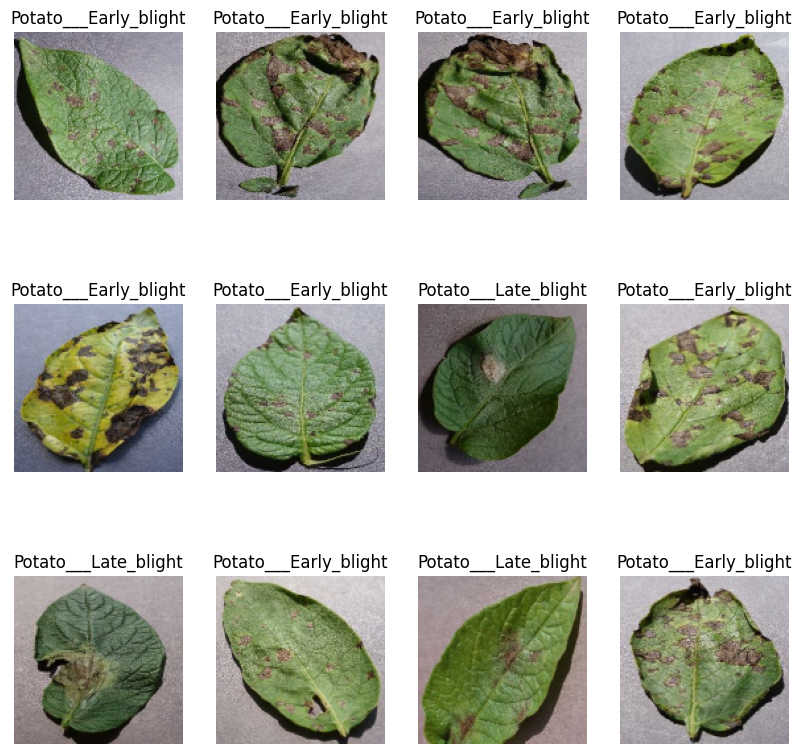

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
# Split the dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
# Prefetching for performance boost
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Image resizing to uniform format
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [15]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# Early stopping callback to stop training when validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
# Define model building function for different architectures
def build_model(model_type='VGG16'):
    base_model = None
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

    if model_type == 'VGG16':
        base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_type == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_type == 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_type == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    base_model.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model


Training VGG16...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.6104 - loss: 3.1100 - val_accuracy: 0.8333 - val_loss: 0.4677
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.8824 - loss: 0.4003 - val_accuracy: 0.9323 - val_loss: 0.1702
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9058 - loss: 0.2860 - val_accuracy: 0.9635 - val_loss: 0.1023
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.9186 - loss: 0.2658 - val_accuracy: 0.9583 - val_loss: 0.1339
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.9429 - loss: 0.1755 - val_accuracy: 0.9531 - val_loss: 0.1605
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.9390 - loss: 0.1818 - val_accuracy: 0.9323 - val_loss: 0.1835


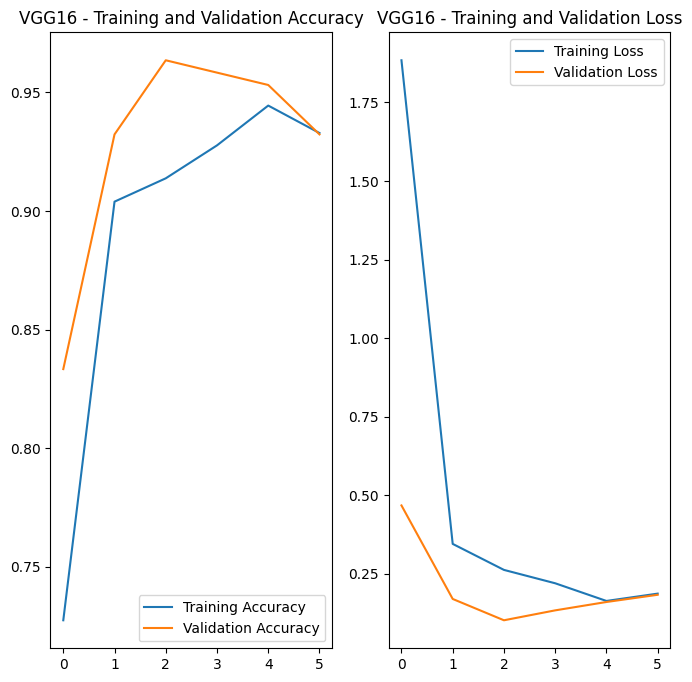

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Test Results for VGG16 - AUC: 0.9659, Precision: 0.8667, Recall: 0.8774, F1 Score: 0.8718

Training MobileNetV2...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.6511 - loss: 0.8075 - val_accuracy: 0.8802 - val_loss: 0.2918
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.8708 - loss: 0.3261 - val_accuracy: 0.9375 - val_loss: 0.2261
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9048 - loss: 0.2478 - val_accuracy: 0.9375 - val_loss: 0.2022
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8992 - loss: 0.2508 - val_accuracy: 0.9375 - val_loss: 0.1744
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9059 - loss: 0.2182 - val_accuracy: 0.9167 - val_loss: 0.2243
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.9237 - loss: 0.2213 - val

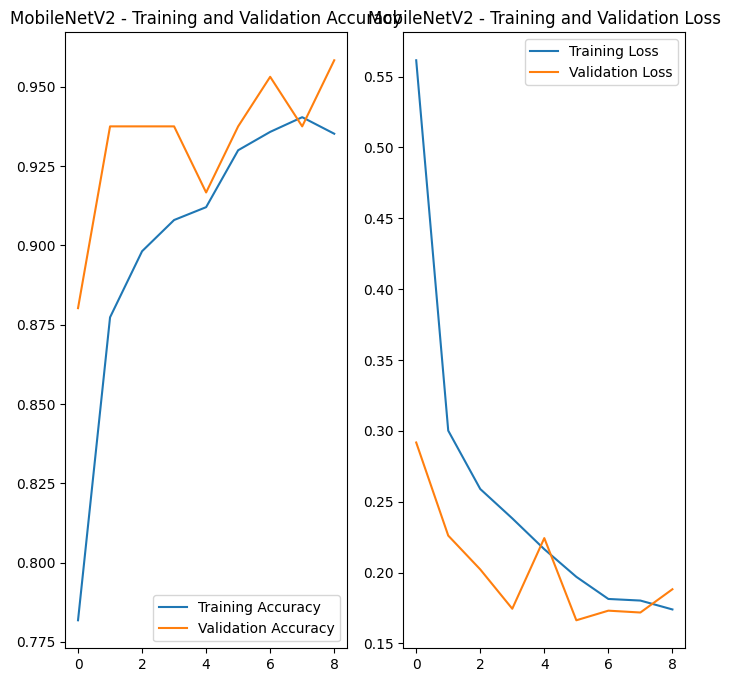

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test Results for MobileNetV2 - AUC: 0.9859, Precision: 0.9591, Recall: 0.8942, F1 Score: 0.9217

Training InceptionV3...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step - accuracy: 0.4874 - loss: 56.8634 - val_accuracy: 0.7083 - val_loss: 5.9308
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6669 - loss: 6.4296 - val_accuracy: 0.6875 - val_loss: 2.7854
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.6971 - loss: 2.3878 - val_accuracy: 0.6771 - val_loss: 1.4876
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.7245 - loss: 1.9043 - val_accuracy: 0.5625 - val_loss: 2.9407
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.7080 - loss: 1.5924 - val_accuracy: 0.7448 - val_loss: 1.2755
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.7460 - loss: 1.2947

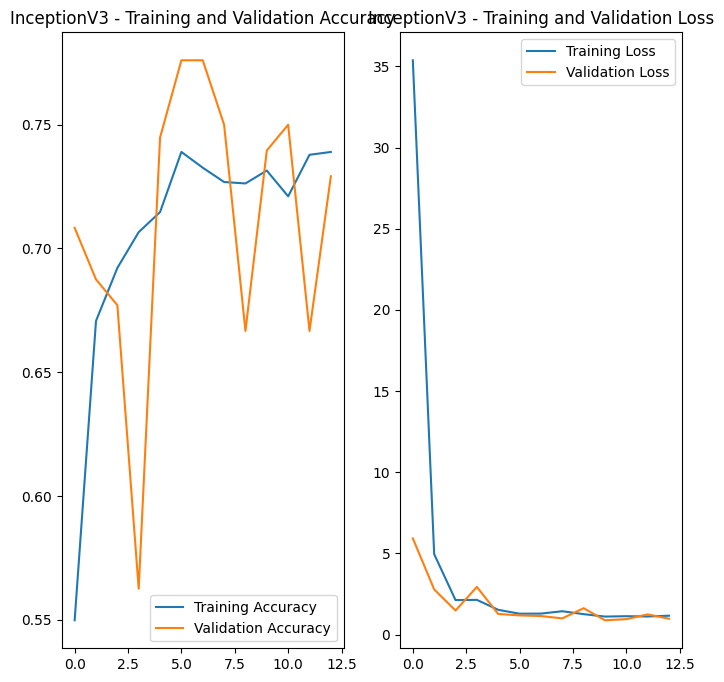

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Test Results for InceptionV3 - AUC: 0.8435, Precision: 0.6137, Recall: 0.6273, F1 Score: 0.6102

Training EfficientNetB0...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 419ms/step - accuracy: 0.7284 - loss: 0.6142 - val_accuracy: 0.9531 - val_loss: 0.1637
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.9459 - loss: 0.1523 - val_accuracy: 0.9635 - val_loss: 0.0998
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9543 - loss: 0.1223 - val_accuracy: 0.9792 - val_loss: 0.0709
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9640 - loss: 0.1026 - val_accuracy: 0.9740 - val_loss: 0.0717
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9736 - loss: 0.0721 - val_accuracy: 1.0000 - val_loss: 0.0447
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9780 - loss: 0.05

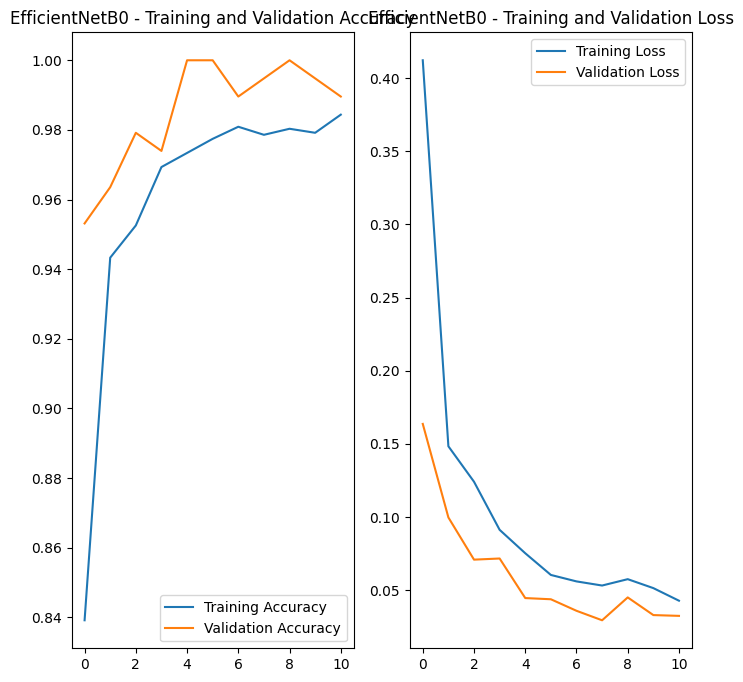

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test Results for EfficientNetB0 - AUC: 0.9997, Precision: 0.9706, Recall: 0.9700, F1 Score: 0.9702


In [20]:
import numpy as np
# Train and evaluate each model
models_to_evaluate = ['VGG16', 'MobileNetV2', 'InceptionV3', 'EfficientNetB0']
history_dict = {}
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name in models_to_evaluate:
    print(f"\nTraining {model_name}...")
    model = build_model(model_type=model_name)

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot accuracy and loss for each model
    plt.figure(figsize=(8, 8))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')

    plt.show()


    # Evaluate the model on the test set
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions)

    # Calculate AUC, precision, recall, and F1 score
    auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')
    precision = precision_score(y_true, [np.argmax(pred) for pred in y_pred], average='macro', zero_division=1)
    recall = recall_score(y_true, [np.argmax(pred) for pred in y_pred], average='macro', zero_division=1)
    f1 = f1_score(y_true, [np.argmax(pred) for pred in y_pred], average='macro', zero_division=1)

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Test Results for {model_name} - AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store history for plotting
    history_dict[model_name] = history



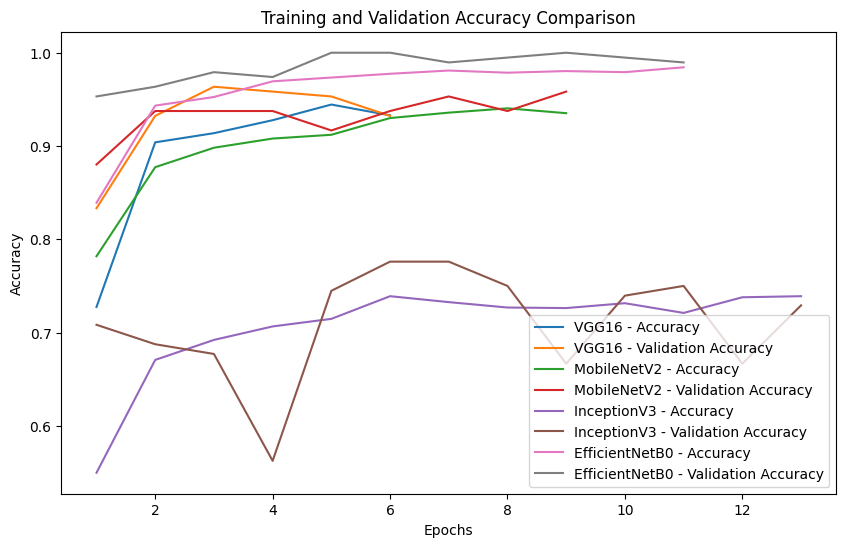

In [21]:
# Plot AUC-ROC comparison
plt.figure(figsize=(10, 6))

for i, model_name in enumerate(models_to_evaluate):
    plt.plot(range(1, len(history_dict[model_name].history['accuracy']) + 1),
             history_dict[model_name].history['accuracy'], label=f'{model_name} - Accuracy')
    plt.plot(range(1, len(history_dict[model_name].history['accuracy']) + 1),
             history_dict[model_name].history['val_accuracy'], label=f'{model_name} - Validation Accuracy')

plt.title("Training and Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

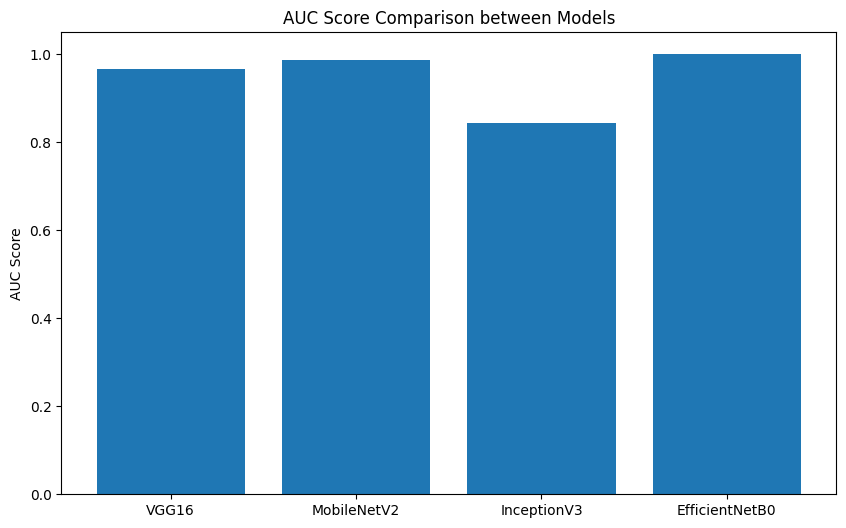

In [22]:
# Plot AUC-ROC comparison
plt.figure(figsize=(10, 6))
plt.bar(models_to_evaluate, auc_scores)
plt.title("AUC Score Comparison between Models")
plt.ylabel("AUC Score")
plt.show()

In [23]:
# Save the best model
best_model_idx = np.argmax(auc_scores)
best_model_name = models_to_evaluate[best_model_idx]
best_model = build_model(model_type=best_model_name)
best_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])

best_model.save(f'{best_model_name}_best_model.keras')

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 410ms/step - accuracy: 0.7532 - loss: 0.5901 - val_accuracy: 0.9688 - val_loss: 0.1360
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9353 - loss: 0.1547 - val_accuracy: 0.9688 - val_loss: 0.0953
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9689 - loss: 0.0918 - val_accuracy: 0.9896 - val_loss: 0.0701
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9759 - loss: 0.0776 - val_accuracy: 0.9948 - val_loss: 0.0569
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9767 - loss: 0.0661 - val_accuracy: 0.9948 - val_loss: 0.0387
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.9804 - loss: 0.0634 - val_accuracy: 1.0000 - val_loss: 0.0305
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9810 - loss: 0.0526 - val_accuracy: 1.0000 - val_loss: 0.0287
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.9786 - loss: 0.0548 - val_accuracy: 1

In [24]:
# Download the model
from google.colab import files
files.download(f'{best_model_name}_best_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define constants
BATCH_SIZE = 64
IMAGE_SIZE = 256  # Custom CNN requires image size of 256
CHANNELS = 3
n_classes = 3
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 30
# Load dataset
dataset = image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
class_names = dataset.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

# Split the dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Early stopping callback to stop training when validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model building function for different architectures
def build_model(model_type='VGG16'):
    base_model = None
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

    if model_type == 'VGG16':
        base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_type == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_type == 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_type == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    base_model.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

# Custom CNN model
def build_custom_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=3):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

# Train and evaluate each model
models_to_evaluate = ['VGG16', 'MobileNetV2', 'InceptionV3', 'EfficientNetB0', 'CustomCNN']
history_dict = {}
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name in models_to_evaluate:
    print(f"\nTraining {model_name}...")

    if model_name == 'CustomCNN':
        model = build_custom_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=n_classes)
    else:
        model = build_model(model_type=model_name)

    # Fit the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot accuracy and loss for each model
    plt.figure(figsize=(8, 8))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')

    plt.show()

    # Evaluate the model on the test set
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions)

    # Calculate AUC, precision, recall, and F1 score
    auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')
    precision = precision_score(y_true, [np.argmax(pred) for pred in y_pred], average='macro', zero_division=1)
    recall = recall_score(y_true, [np.argmax(pred) for pred in y_pred], average='macro', zero_division=1)
    f1 = f1_score(y_true, [np.argmax(pred) for pred in y_pred], average='macro', zero_division=1)

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Test Results for {model_name} - AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store history for plotting
    history_dict[model_name] = history

# Plot AUC-ROC comparison
plt.figure(figsize=(10, 6))

for i, model_name in enumerate(models_to_evaluate):
    plt.plot(range(1, len(history_dict[model_name].history['accuracy']) + 1),
             history_dict[model_name].history['accuracy'], label=f'{model_name} - Accuracy')
    plt.plot(range(1, len(history_dict[model_name].history['accuracy']) + 1),
             history_dict[model_name].history['val_accuracy'], label=f'{model_name} - Validation Accuracy')

plt.title("Training and Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot AUC-ROC comparison
plt.figure(figsize=(10, 6))
plt.bar(models_to_evaluate, auc_scores)
plt.title("AUC Score Comparison between Models")
plt.ylabel("AUC Score")
plt.show()

# Save the best model
best_model_idx = np.argmax(auc_scores)
best_model_name = models_to_evaluate[best_model_idx]
best_model = build_model(model_type=best_model_name) if best_model_name != 'CustomCNN' else build_custom_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=n_classes)
best_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])

best_model.save(f'{best_model_name}_best_model.keras')

# Download the model
from google.colab import files
files.download(f'{best_model_name}_best_model.keras')


Found 2152 files belonging to 3 classes.
Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Training VGG16...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5946 - loss: 1.6204 - val_accuracy: 0.8906 - val_loss: 0.2819
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 901ms/step - accuracy: 0.9225 - loss: 0.2325 - val_accuracy: 0.9271 - val_loss: 0.2044
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 920ms/step - accuracy: 0.9268 - loss: 0.2078 - val_accuracy: 0.9427 - val_loss: 0.1557
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 876ms/step - accuracy: 0.9402 - loss: 0.1572 - val_accuracy: 0.9427 - val_loss: 0.1400
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 915ms/step - accuracy: 0.9540 - loss: 0.1373 - val_accuracy: 0.9427 - val_loss: 0.1231
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step - accuracy: 0.9686 - loss: 0.0904 - val_accuracy: 0.9479 - val_loss: 0.0940
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 896ms/step - accuracy: 0.9778 - loss: 0.0660